<a href="https://colab.research.google.com/github/mrazimi99/deep-packet/blob/main/DeepPacket.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install scapy

     |████████████████████████████████| 1.1MB 4.3MB/s 
  Created wheel for scapy: filename=scapy-2.4.5-py2.py3-none-any.whl size=1261554 sha256=e2c3334fb2f68425199f4daf98e38a1b82ed84ddc15f4f1a826c2baab1cf0241
  Stored in directory: /root/.cache/pip/wheels/31/80/dc/d5fc39b70e1af4f4636356c849de414a76e83a89d8ee9cd78f
Successfully built scapy


In [2]:
from pathlib import Path
import os
import os.path
import numpy as np
import pandas as pd
from joblib import Parallel, delayed
from scapy.compat import raw
from scapy.layers.inet import IP, UDP
from scapy.layers.l2 import Ether
from scapy.packet import Padding
from scapy.utils import rdpcap, PcapReader
from scipy import sparse
from sklearn.model_selection import train_test_split
from imblearn.under_sampling import RandomUnderSampler

import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
from random import sample
import matplotlib.pyplot as plt
import seaborn as sn
import math

from torch.utils.data import Dataset, DataLoader, random_split
from torch.utils.data.sampler import SubsetRandomSampler

import time
from datetime import timedelta
from datetime import datetime
import pickle
import random
from prettytable import PrettyTable

import sys
sys.path.append('drive/MyDrive/deep_packet')
from utils import should_omit_packet, PREFIX_TO_APP_ID, PREFIX_TO_TRAFFIC_ID, ID_TO_APP, ID_TO_TRAFFIC

/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


In [3]:
def remove_ether_header(packet):
    if Ether in packet:
        return packet[Ether].payload

    return packet


def mask_ip(packet):
    if IP in packet:
        packet[IP].src = '0.0.0.0'
        packet[IP].dst = '0.0.0.0'

    return packet


def pad_udp(packet):
    if UDP in packet:
        # get layers after udp
        layer_after = packet[UDP].payload.copy()

        # build a padding layer
        pad = Padding()
        pad.load = '\x00' * 12

        layer_before = packet.copy()
        layer_before[UDP].remove_payload()
        packet = layer_before / pad / layer_after

        return packet

    return packet


def packet_to_sparse_array(packet, max_length=1500):
    arr = np.frombuffer(raw(packet), dtype=np.uint8)[0: max_length]     # Divide to 255 later
    if len(arr) < max_length:
        pad_width = max_length - len(arr)
        arr = np.pad(arr, pad_width=(0, pad_width), constant_values=0)

    arr = sparse.csr_matrix(arr)
    return arr


def transform_packet(packet):
    if should_omit_packet(packet):
        return None

    packet = remove_ether_header(packet)
    packet = pad_udp(packet)
    packet = mask_ip(packet)

    arr = packet_to_sparse_array(packet)

    return arr

In [4]:
pcaps = 'drive/MyDrive/deep_packet/Pcaps/vpn/'
cache = 'drive/MyDrive/deep_packet/Dataset/vpn_dataset.pickle'
dataset = []

# if not os.path.isfile(cache):
if False:
    for path in os.listdir(pcaps):
        print('Processing ' + path)
        for i, packet in enumerate(rdpcap(pcaps + path)):
            arr = transform_packet(packet)
            if arr is not None:
                # get labels for app identification
                prefix = path.split('.')[0].lower()
                app_label = PREFIX_TO_APP_ID.get(prefix)
                traffic_label = PREFIX_TO_TRAFFIC_ID.get(prefix)
                row = {
                    'app_label': app_label,
                    'traffic_label': traffic_label,
                    'feature': arr.todense().tolist()[0]
                }
                dataset.append(row)
    
    with open(cache, 'wb') as f:
        pickle.dump(dataset, f)
else:
    dataset = []
    data_dir = 'drive/MyDrive/deep_packet/Dataset/'
    for path in os.listdir(data_dir):
        with open(data_dir + path, 'rb') as f:
            dataset.extend(pickle.load(f))

In [5]:
# traffic_labels = [row['traffic_label'] for row in dataset]
# traffic_classes = set(traffic_labels)
# traffic_train_all, traffic_test_all = train_test_split(dataset, test_size=0.2, random_state=42, stratify=traffic_labels)

app_labels = [row['app_label'] for row in dataset]
app_classes = set(app_labels)
app_train_all, app_test_all = train_test_split(dataset, test_size=0.2, random_state=42, stratify=app_labels)

del dataset

In [6]:
# undersample = RandomUnderSampler(sampling_strategy='majority')
# traffic_features = [elem['feature'] for elem in traffic_train_all]
# train_traffic_labels = [elem['traffic_label'] for elem in traffic_train_all]
# traffic_train, traffic_y = undersample.fit_resample(traffic_features, train_traffic_labels)
# del traffic_features, train_traffic_labels, traffic_train_all

undersample = RandomUnderSampler(sampling_strategy='majority')
app_features = [elem['feature'] for elem in app_train_all]
train_app_labels = [elem['app_label'] for elem in app_train_all]
app_train, app_y = undersample.fit_resample(app_features, train_app_labels)
del app_features, train_app_labels, app_train_all

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [7]:
# traffic_train_final = [{'feature': torch.from_numpy(np.array([a/255.0 for a in f.tolist()], dtype=np.float32)), 'label': l} for f, l in zip(traffic_train, traffic_y)]
# del traffic_train, traffic_y
# traffic_test_final = [{'feature': torch.from_numpy(np.array([a/255.0 for a in elem['feature']], dtype=np.float32)), 'label': elem['traffic_label']} for elem in traffic_test_all]
# del traffic_test_all

app_train_final = [{'feature': torch.from_numpy(np.array([a/255.0 for a in f.tolist()], dtype=np.float32)), 'label': l} for f, l in zip(app_train, app_y)]
del app_train, app_y
app_test_final = [{'feature': torch.from_numpy(np.array([a/255.0 for a in elem['feature']], dtype=np.float32)), 'label': elem['app_label']} for elem in app_test_all]
del app_test_all

In [8]:
batch_size = 64
num_workers = 2

# random.shuffle(traffic_train_final)
# traffic_train_loader = torch.utils.data.DataLoader(traffic_train_final, batch_size=batch_size, num_workers=num_workers)
# traffic_test_loader = torch.utils.data.DataLoader(traffic_test_final, batch_size=batch_size, num_workers=num_workers)

random.shuffle(app_train_final)
app_train_loader = torch.utils.data.DataLoader(app_train_final, batch_size=batch_size, num_workers=num_workers)
app_test_loader = torch.utils.data.DataLoader(app_test_final, batch_size=batch_size, num_workers=num_workers)

In [9]:
class Model(nn.Module):
    def __init__(self, input_num, middle_layers, output_num, act):
        super(Model, self).__init__()
        self.layers = nn.ModuleList()
        self.acts = []

        self.layers.append(nn.Linear(input_num, middle_layers[0]))
        self.acts.append(act)

        for i in range(len(middle_layers) - 1):
            self.layers.append(nn.Linear(middle_layers[i], middle_layers[i + 1]))
            self.acts.append(act)

        self.layers.append(nn.Linear(middle_layers[-1], output_num))

    def forward(self, x):

        x = x.view(x.size(0), -1)

        for i in range(len(self.layers) - 1):
            x = self.layers[i](x)
            x = self.acts[i](x)

        x = self.layers[-1](x)
        return x

In [10]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [11]:
def fit(model, train_loader, device, criterion, optimizer, num_epochs=10):
    total_time = 0.
    loss_per_epoch = {e + 1 : 0 for e in range(num_epochs)}

    for epoch in range(num_epochs):
        train_loss = 0.
        d1 = datetime.now()

        for elem in train_loader:
            byte_array = elem['feature'].to(device)
            labels = elem['label'].to(device)

            # Clear gradients w.r.t. parameters
            optimizer.zero_grad()

            # Forward pass to get output/logits
            outputs = model(byte_array)

            # Calculate Loss: softmax --> cross entropy loss
            loss = criterion(outputs, labels)

            # Getting gradients w.r.t. parameters
            loss.backward()

            # Updating parameters
            optimizer.step()
            train_loss += loss.item()

        average_loss = train_loss / len(train_loader)
        d2 = datetime.now()
        delta = d2 - d1
        seconds = float(delta.total_seconds())
        total_time += seconds
        loss_per_epoch[epoch + 1] = average_loss
        print('epoch %d, train_loss: %.3f, time elapsed: %s seconds' % (epoch + 1, average_loss, seconds))

    if math.isnan(max(loss_per_epoch.values())):
        print('Could not plot for nan losses.')
    else:
        plt.plot(list(loss_per_epoch.keys()), list(loss_per_epoch.values()))
        plt.title('Avreage Loss Per Epoch')
        plt.xlabel('Epoch')
        plt.ylabel('Aerage Loss')
        plt.xlim(1, num_epochs + 1)
        plt.ylim(0, max(loss_per_epoch.values()) + 1)
        plt.show()

    print('total training time: %.3f minutes' % (total_time / 60))

In [12]:
def test_model_accuracy(model, test_loader, classes):
    # Calculate Accuracy         
    correct = 0.
    total = 0.
    correct_predicted = {id : 0 for id in range(len(classes))}
    num_of_labels = {id : 0 for id in range(len(classes))}
    all_predicted = {id : 0 for id in range(len(classes))}
    confusion = [ [0] * len(classes) for _ in range(len(classes))]

    # Iterate through test dataset
    with torch.no_grad():
      for elem in test_loader:
        byte_array = elem['feature'].to(device)
        labels = elem['label']
        outputs = model(byte_array)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)

        for p, l in zip(predicted, labels):
            num_of_labels[l.item()] += 1
            pc = p.to('cpu').item()
            all_predicted[pc] += 1
            confusion[l][pc] += 1

            if p == l:
                correct_predicted[pc] += 1

        correct += (predicted.to('cpu') == labels).sum().item()

    accuracy = 100 * correct / total
    print('Accuracy: {}%'.format(accuracy))
    return confusion, [x / y if y else 0 for x, y in zip(correct_predicted.values(), all_predicted.values())], [x / y if y else 0 for x, y in zip(correct_predicted.values(), num_of_labels.values())]

In [13]:
def analyse(model, train_loader, test_loader, classes, task):
    print('Train ', end='')
    _, train_rcs, train_prs = test_model_accuracy(model, train_loader, classes)
    print('Test ', end='')
    confusion, test_rcs, test_prs = test_model_accuracy(model, test_loader, classes)
    test_f1 = []
    table = PrettyTable(['Class', 'Rc', 'Pr', 'F1'])

    for i, (rc, pr) in enumerate(zip(test_rcs, test_prs)):
        f1 = 2 * rc * pr / (rc + pr) if (rc + pr) else 0
        test_f1.append(f1)
        class_name = ID_TO_TRAFFIC.get(classes[i]) if task == 'traffic' else ID_TO_APP.get(classes[i])
        table.add_row([class_name, str(round(rc, 3)), str(round(pr, 3)), str(round(f1, 3))])

    np_rcs = np.array(test_rcs)
    rc_avg = np_rcs[np.nonzero(np_rcs)].mean()
    np_prs = np.array(test_prs)
    pr_avg = np_prs[np.nonzero(np_prs)].mean()
    np_f1s = np.array(test_f1)
    f1_avg = np_f1s[np.nonzero(np_f1s)].mean()
    table.add_row(['Available Classes Avg', str(round(rc_avg, 3)), str(round(pr_avg, 3)), str(round(f1_avg, 3))])
    print(table)

    class_names = [ID_TO_TRAFFIC.get(c) if task == 'traffic' else ID_TO_APP.get(c) for c in classes]
    plt.figure(figsize=(30, 9), dpi= 80, facecolor='w', edgecolor='k')
    plt.bar([i - 0.1 for i in range(len(classes))], train_prs, width=0.2, label='Train')
    plt.bar([i + 0.1 for i in range(len(classes))], test_prs, width=0.2, label='Test')
    plt.legend()
    plt.xlim(-0.2, len(classes))
    plt.xticks(list(range(len(classes))), class_names, rotation='vertical')
    plt.title('Comparision Between Test and Train Accuracies')
    plt.xlabel('Category')
    plt.ylabel('Accuracy')
    plt.show()

    df_cm = pd.DataFrame(confusion, index = [i for i in class_names], columns = [i for i in class_names])
    plt.figure(figsize = (15,10))
    sn.heatmap(df_cm, annot=True)

In [14]:
input_vector = 1500

# output_len = max(traffic_classes) + 1
output_len = max(app_classes) + 1

model = Model(input_vector, [200, 100, 50] , output_len, F.relu)
model = model.to(device)

learning_rate = 0.05
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

In [15]:
# print(traffic_classes)
print(app_classes)

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16}


epoch 1, train_loss: 0.981, time elapsed: 15.48329 seconds
epoch 2, train_loss: 0.369, time elapsed: 15.049286 seconds
epoch 3, train_loss: 0.230, time elapsed: 15.080395 seconds
epoch 4, train_loss: 0.175, time elapsed: 15.018443 seconds
epoch 5, train_loss: 0.162, time elapsed: 15.110638 seconds
epoch 6, train_loss: 0.143, time elapsed: 14.941427 seconds
epoch 7, train_loss: 0.122, time elapsed: 15.056876 seconds
epoch 8, train_loss: 0.090, time elapsed: 15.016281 seconds
epoch 9, train_loss: 0.107, time elapsed: 15.134505 seconds
epoch 10, train_loss: 0.086, time elapsed: 15.099943 seconds
epoch 11, train_loss: 0.100, time elapsed: 14.828988 seconds
epoch 12, train_loss: 0.068, time elapsed: 15.097029 seconds
epoch 13, train_loss: 0.080, time elapsed: 14.916985 seconds
epoch 14, train_loss: 0.063, time elapsed: 15.14911 seconds
epoch 15, train_loss: 0.078, time elapsed: 15.018989 seconds
epoch 16, train_loss: 0.074, time elapsed: 15.073492 seconds
epoch 17, train_loss: 0.060, time e

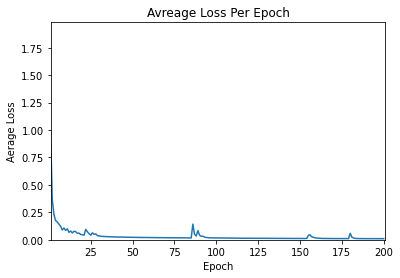

total training time: 49.859 minutes


In [17]:
fit(model, traffic_train_loader, device, criterion, optimizer, num_epochs=200)

Train Accuracy: 99.57516768464046%
Test Accuracy: 97.50329111625584%
+-----------------------+-------+-------+-------+
|         Class         |   Rc  |   Pr  |   F1  |
+-----------------------+-------+-------+-------+
|          Chat         | 0.954 | 0.966 |  0.96 |
|         Email         | 0.944 | 0.949 | 0.946 |
|     File Transfer     | 0.984 | 0.995 |  0.99 |
|       Streaming       | 0.993 | 0.941 | 0.966 |
|        Torrent        |   0   |   0   |   0   |
|          Voip         | 0.943 | 0.987 | 0.964 |
|       VPN: Chat       | 0.949 | 0.988 | 0.968 |
|   VPN: File Transfer  | 0.991 | 0.993 | 0.992 |
|       VPN: Email      | 0.961 | 0.992 | 0.977 |
|     VPN: Streaming    | 0.994 | 0.996 | 0.995 |
|      VPN: Torrent     | 0.993 | 0.998 | 0.995 |
|       VPN: Voip       | 0.975 | 0.985 |  0.98 |
| Available Classes Avg | 0.971 | 0.981 | 0.976 |
+-----------------------+-------+-------+-------+


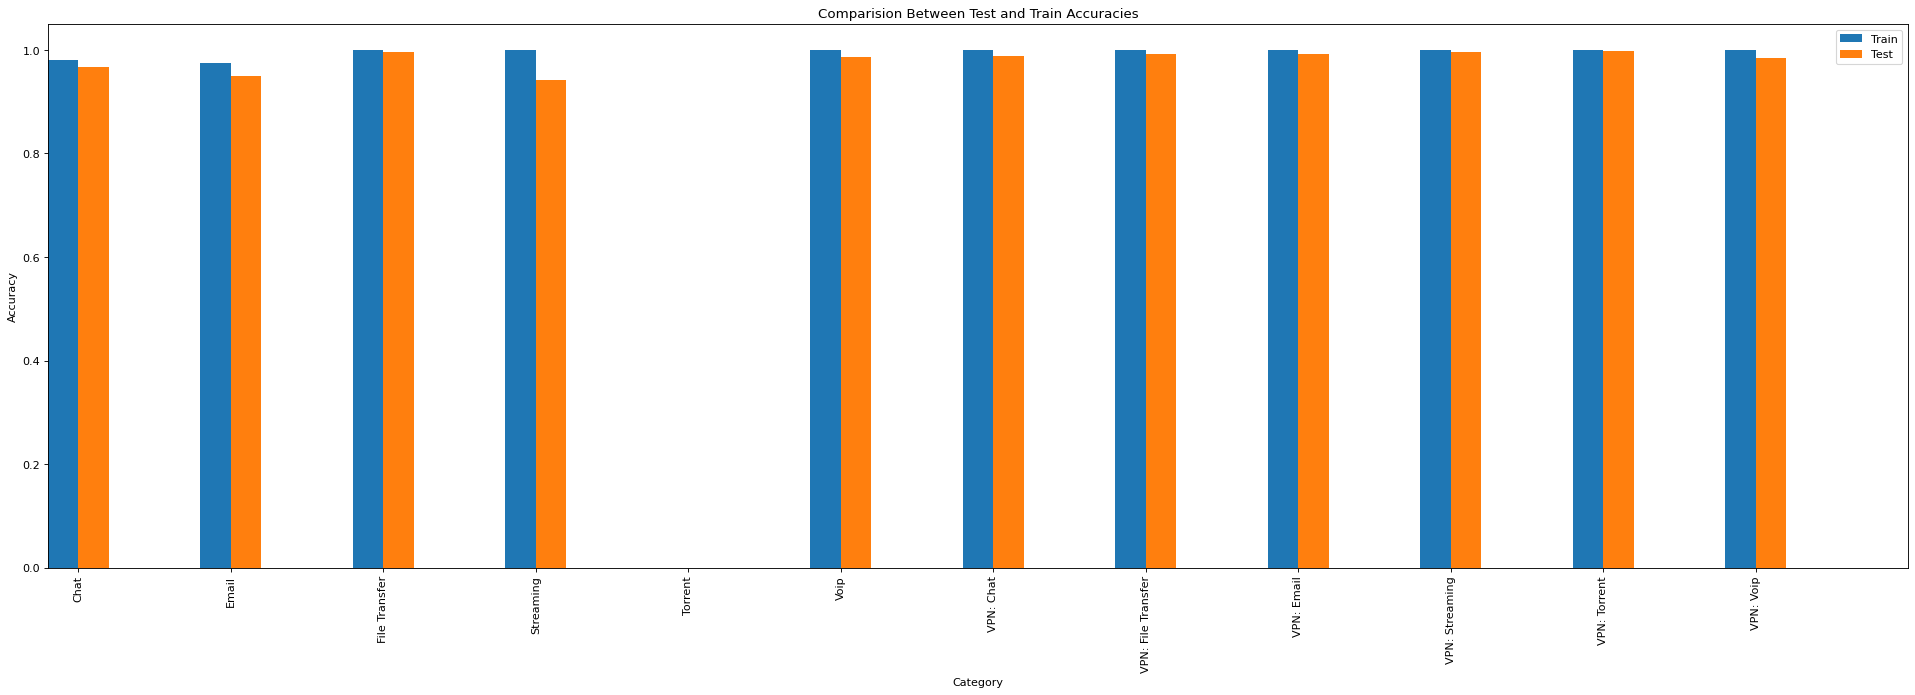

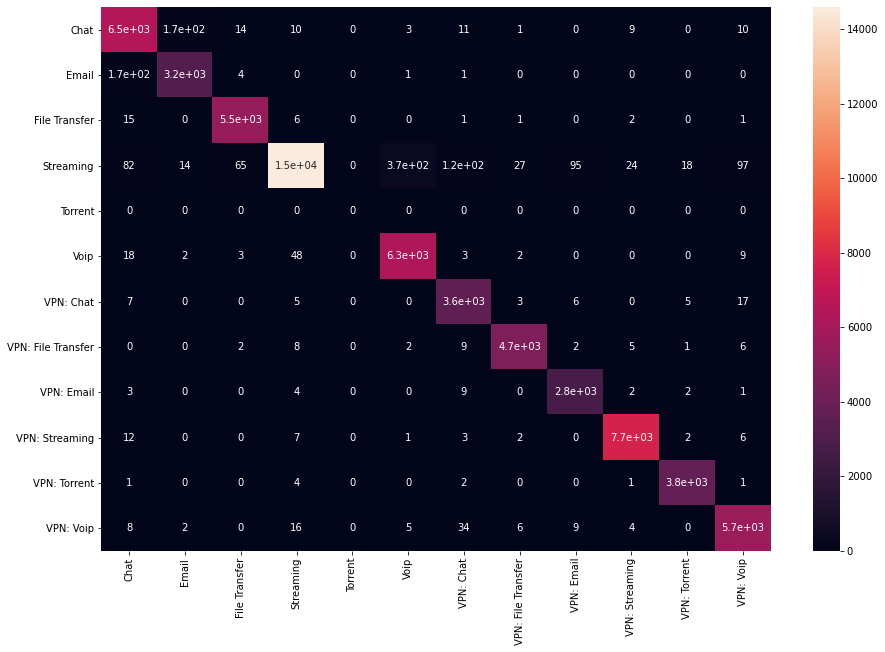

In [51]:
all_traffic_classes = [i for i in range(max(traffic_classes) + 1)]
analyse(model, traffic_train_loader, traffic_test_loader, all_traffic_classes, 'traffic')

epoch 1, train_loss: 1.419, time elapsed: 23.689196 seconds
epoch 2, train_loss: 0.514, time elapsed: 25.219644 seconds
epoch 3, train_loss: 0.296, time elapsed: 24.814066 seconds
epoch 4, train_loss: 0.235, time elapsed: 24.206086 seconds
epoch 5, train_loss: 0.168, time elapsed: 23.837295 seconds
epoch 6, train_loss: 0.233, time elapsed: 24.098337 seconds
epoch 7, train_loss: 0.195, time elapsed: 24.677051 seconds
epoch 8, train_loss: 0.141, time elapsed: 24.436965 seconds
epoch 9, train_loss: 0.160, time elapsed: 24.257717 seconds
epoch 10, train_loss: 0.183, time elapsed: 24.532205 seconds
epoch 11, train_loss: 0.140, time elapsed: 23.81713 seconds
epoch 12, train_loss: 0.137, time elapsed: 24.818257 seconds
epoch 13, train_loss: 0.170, time elapsed: 24.068369 seconds
epoch 14, train_loss: 0.116, time elapsed: 24.215917 seconds
epoch 15, train_loss: 0.098, time elapsed: 24.113099 seconds
epoch 16, train_loss: 0.078, time elapsed: 24.475852 seconds
epoch 17, train_loss: 0.133, time 

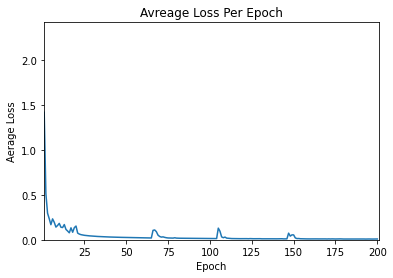

total training time: 75.433 minutes


In [16]:
fit(model, app_train_loader, device, criterion, optimizer, num_epochs=200)

Train Accuracy: 99.70143706640238%
Test Accuracy: 97.30658071935478%
+-----------------------+-------+-------+-------+
|         Class         |   Rc  |   Pr  |   F1  |
+-----------------------+-------+-------+-------+
|        AIM Chat       | 0.855 |  0.94 | 0.896 |
|         Email         | 0.932 | 0.983 | 0.957 |
|        Facebook       | 0.941 | 0.972 | 0.956 |
|          FTPS         | 0.997 | 0.999 | 0.998 |
|         Gmail         | 0.909 | 0.939 | 0.924 |
|        Hangouts       | 0.953 | 0.982 | 0.967 |
|          ICQ          | 0.963 | 0.934 | 0.948 |
|        Netflix        | 0.998 | 0.999 | 0.998 |
|          SCP          | 0.992 | 0.994 | 0.993 |
|          SFTP         | 0.998 | 0.997 | 0.997 |
|         Skype         | 0.993 | 0.869 | 0.927 |
|        Spotify        | 0.983 | 0.981 | 0.982 |
|        Torrent        | 0.997 | 0.999 | 0.998 |
|          Tor          | 0.997 | 0.999 | 0.998 |
|         Vimeo         | 0.986 | 0.981 | 0.983 |
|       Voipbuster      | 0.987

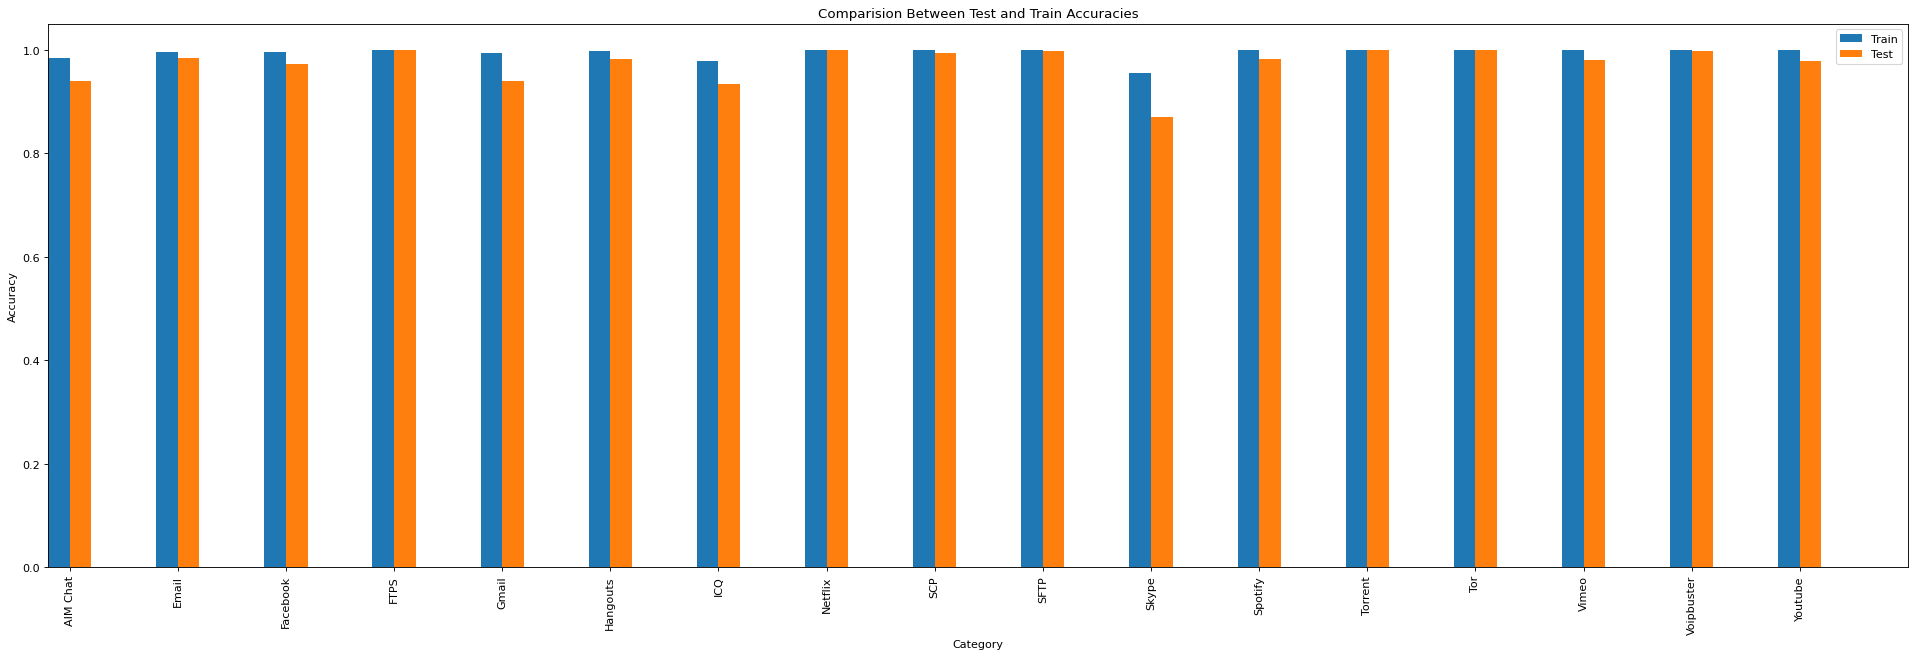

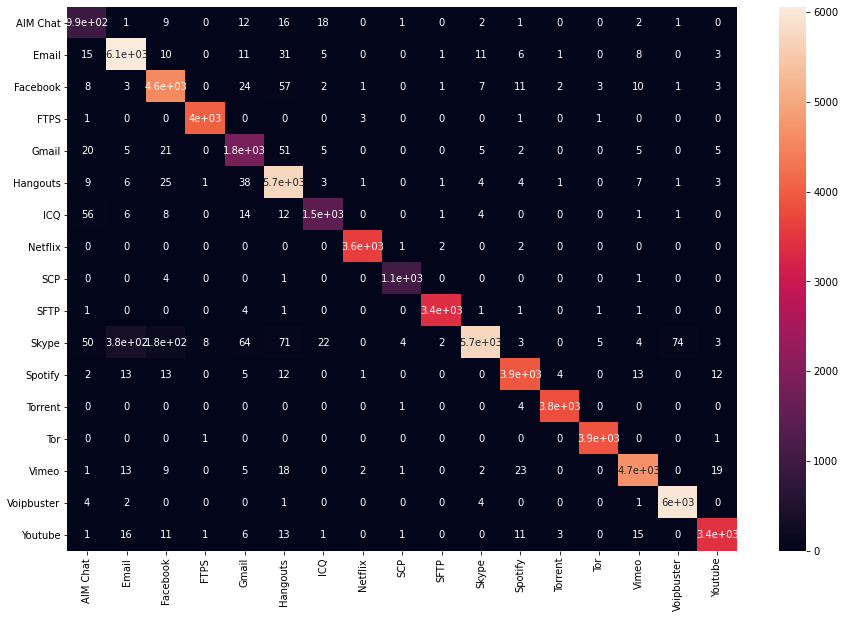

In [17]:
all_app_classes = [i for i in range(max(app_classes) + 1)]
analyse(model, app_train_loader, app_test_loader, all_app_classes, 'app')

## Combining Random Oversampling and Undersampling

In [ ]:
undersample = RandomUnderSampler(sampling_strategy=0.6)
traffic_features = [elem['feature'] for elem in traffic_train_all]
train_traffic_labels = [elem['traffic_label'] for elem in traffic_train_all]
traffic_train, traffic_y = undersample.fit_resample(traffic_features, train_traffic_labels)
del traffic_features, train_traffic_labels, traffic_train_all
oversample = RandomOverSampler(sampling_strategy='majority')
traffic_train, traffic_y = oversample.fit_resample(traffic_train, traffic_y)

# undersample = RandomUnderSampler(sampling_strategy=0.6)
# app_features = [elem['feature'] for elem in app_train_all]
# train_app_labels = [elem['app_label'] for elem in app_train_all]
# app_train, app_y = undersample.fit_resample(app_features, train_app_labels)
# del app_features, train_app_labels, app_train_all
# oversample = RandomOverSampler(sampling_strategy='majority')
# app_train, app_y = oversample.fit_resample(app_train, app_y)